In [31]:
# Compute uvgeo from SSH
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import sys
sys.path.append("/Odyssey/private/t22picar/tools")
from plot_tools import plot_uv_map, plot_map_zoom_only
from datetime import datetime, timedelta

from jaxparrow import cyclogeostrophy, geostrophy


lat_mask=5
depth = "15m"

file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_{depth}_2010-2018.nc"
maps_4th = xr.open_dataset(file_data)
#maps=maps.sel(time="2010-01-01")
lon_4th = maps_4th.lon.values
lat_4th = maps_4th.lat.values

file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_15m_2010.nc"
maps = xr.open_dataset(file_data)
#maps=maps.sel(depth=maps.depth[0])
maps=maps.sel(depth=maps.depth[0]).sel(time="2010-01-01")
maps = maps.rename({"latitude": "lat"})
maps = maps.rename({"longitude": "lon"})
maps_4th

# Get longitudes and latitudes
lon = maps.lon.values
lat = maps.lat.values
lon2D, lat2D = numpy.meshgrid(lon, lat)
#lat2D, lon2D  = numpy.meshgrid(lat, lon)

In [33]:
lon2D.shape

(2041, 4320)

In [7]:
#maps_4th = maps_4th.drop_vars("mlotst")
maps_4th = maps_4th.rename({"zos": "uageo"})
maps_4th = maps_4th.rename({"thetao": "vageo"})
maps_4th = maps_4th.rename({"uo": "ugeo"})
maps_4th = maps_4th.rename({"vo": "vgeo"})


In [8]:
from tqdm import tqdm  # Importer tqdm
from IPython.display import clear_output


In [11]:

start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 1, 3)
current_date = start_date
time_index=0
ugeo_list=[]
vgeo_list=[]
uageo_list=[]
vageo_list=[]
time_list=[]

# Initialiser la barre de progression
total_iterations = 3287
pbar = tqdm(total=total_iterations, desc="Ajout des pas de temps")

while current_date < end_date:
    print(current_date)

    year=current_date.year
    file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_15m_{year}.nc"
    maps = xr.open_dataset(file_data)
    maps=maps.sel(depth=maps.depth[0]).sel(time=current_date)

    #Compute geostrophy
    (u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(maps.zos.values, lat2D, lon2D)


    # Créer un DataArray pour "u"
    u_geo_xr = xr.DataArray(
        u_geo,
        dims=("lat", "lon"),
        coords={

            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="ugeo"
    ).expand_dims(time=[current_date])

    # Créer un DataArray pour "u"
    v_geo_xr = xr.DataArray(
        v_geo,
        dims=("lat", "lon"),
        coords={

            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="vgeo"
    ).expand_dims(time=[current_date])

    #print("Interpolation grille d'origine")
        # Interpolation grille d'origine
    u_geo_xr_int = u_geo_xr.interp({"lat":lat, "lon":lon}, method="linear")
    v_geo_xr_int = v_geo_xr.interp({"lat":lat, "lon":lon}, method="linear")

    u_ageo = maps.uo.values - u_geo_xr_int.values[0]
    v_ageo = maps.vo.values - v_geo_xr_int.values[0]

    
    # Créer un DataArray pour "u"
    u_ageo_xr = xr.DataArray(
        u_ageo,
        dims=("lat", "lon"),
        coords={
            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="uageo"
    ).expand_dims(time=[current_date])

    # Créer un DataArray pour "u"
    v_ageo_xr = xr.DataArray(
        v_ageo,
        dims=("lat", "lon"),
        coords={

            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="vageo"
    ).expand_dims(time=[current_date])
    

    #print("interp 4th ...")
    u_geo_4th = u_geo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")
    v_geo_4th = v_geo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")
    u_ageo_4th = u_ageo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")
    v_ageo_4th = v_ageo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")

    # Ajouter à la liste
    ugeo_list.append(u_geo_4th)
    vgeo_list.append(v_geo_4th)
    uageo_list.append(u_ageo_4th)
    vageo_list.append(v_ageo_4th)
    time_list.append(current_date)

    current_date += timedelta(days=1)
    time_index=time_index+1
    pbar.update(1)
    # Nettoyer le terminal
    #clear_output(wait=True)


# Fermer la barre de progression
pbar.close()


Ajout des pas de temps:   0%|          | 0/3287 [01:25<?, ?it/s]

2010-01-01 00:00:00


TypeError: div got incompatible shapes for broadcasting: (2041, 4320), (4320, 2041).

In [45]:
# Concaténer tous les DataArrays le long de la dimension "time"
ugeo = xr.concat(ugeo_list, dim="time")
vgeo = xr.concat(vgeo_list, dim="time")
uageo = xr.concat(uageo_list, dim="time")
vageo = xr.concat(vageo_list, dim="time")
# Créer le Dataset final
ds = xr.Dataset({"ugeo": ugeo, "vgeo": vgeo,"uageo": uageo, "vageo": vageo})

# Afficher le Dataset
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 49, lat: 680, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 392B 2010-01-01 2010-01-02 ... 2010-02-18
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    ugeo     (time, lat, lon) float64 384MB nan nan nan nan ... nan nan nan nan
    vgeo     (time, lat, lon) float64 384MB nan nan nan nan ... nan nan nan nan
    uageo    (time, lat, lon) float64 384MB nan nan nan nan ... nan nan nan nan
    vageo    (time, lat, lon) float64 384MB nan nan nan nan ... nan nan nan nan


In [2]:
ls /Odyssey/private/t22picar/data/glorys_{depth}

glorys_15.81m_2019-01-01-2020-01-01.nc  glorys_multivar_15m_2014.nc
glorys_multivar_15m_2010-2018.nc        glorys_multivar_15m_2015.nc
glorys_multivar_15m_2010.nc             glorys_multivar_15m_2016.nc
glorys_multivar_15m_2011.nc             glorys_multivar_15m_2017.nc
glorys_multivar_15m_2012.nc             glorys_multivar_15m_2018.nc
glorys_multivar_15m_2013.nc             glorys_uv_ageos_15m_2010-2018.nc


In [46]:
print("Saving...")
save_file=f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_uv_geo_and_ageo_{depth}_2010-2018.nc"

# Sauvegarder le DataArray en fichier NetCDF
ds.to_netcdf(save_file)

Saving...


In [47]:
maps_4th = xr.open_dataset(save_file)

In [51]:
maps_4th.lat

<xarray.DataArray 'lat' (lat: 680)> Size: 5kB
array([-80.      , -79.749632, -79.499264, ...,  89.499264,  89.749632,
        90.      ])
Coordinates:
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0

In [13]:
(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(maps.zos.values, lat2D, lon2D)


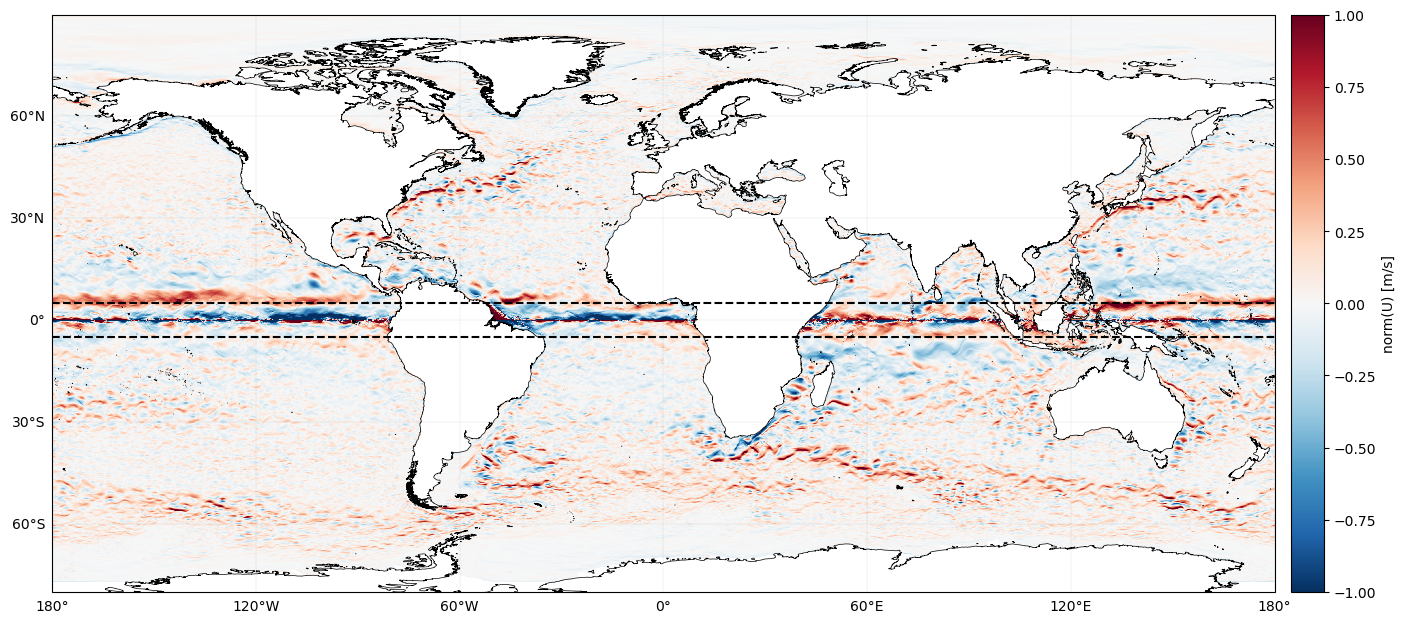

In [15]:
plot_uv_map(u_geo,lon2D,lat2D)

In [18]:
import numpy as np

In [30]:
maps.zos.values.shape

(2041, 4320)

In [ ]:
(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(np.swapaxes(maps.zos.values, 0, 1), np.swapaxes(lat2D, 0, 1), np.swapaxes(lon2D, 0, 1))

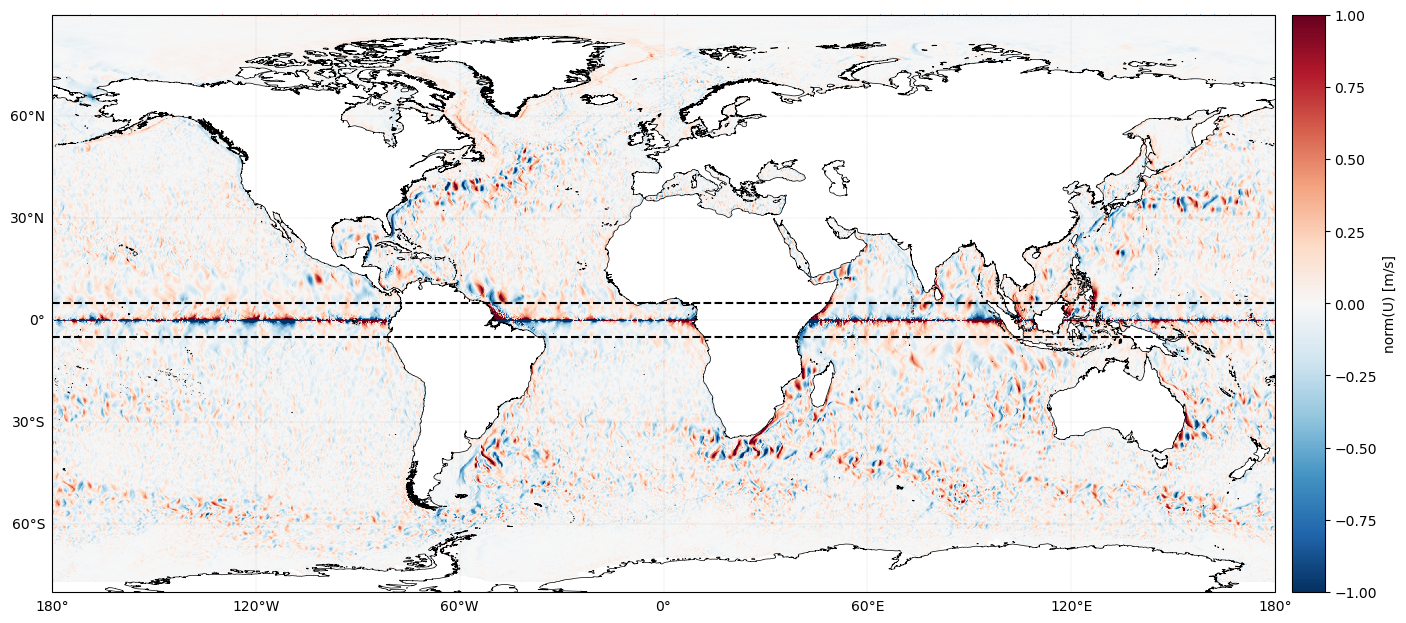

In [29]:
plot_uv_map(u_geo,lon_u,lat_u)